In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from solvers import DensitySolver
from task import BusinessLogic
from utils import get_data

DATA_PATH = '../data'
TERMINAL_DATA_PATH = os.path.join(DATA_PATH, 'terminal_data_hackathon v4.xlsx')
TIMES_DATA_PATH = os.path.join(DATA_PATH, 'times v4.csv')

In [2]:
points = pd.read_excel(TERMINAL_DATA_PATH, sheet_name='TIDS')
tid_to_ind = {tid: i for i, tid in enumerate(points.TID)}
terminals_num = len(points)

columns = ['TID', 'start_value'] + [f'day {i + 1}' for i in range(91)]
incomes = pd.read_excel(TERMINAL_DATA_PATH, sheet_name='Incomes', names=columns)
add_columns = [f'remains {i + 1}' for i in range(91)]
incomes[add_columns] = incomes[columns[1:]].values.cumsum(axis=1)[:, 1:]

moscow = gpd.read_file("ao-shape.zip")
terms = points.set_index('TID').join(incomes.set_index('TID')).reset_index()

In [3]:
terminals, time_matrix = get_data('../data/')
business_logic = BusinessLogic()
solver = DensitySolver(terminals['start_value'].values, time_matrix, business_logic, armored_num=23)
routes = solver.get_routes()

In [4]:
sum([len(route) for route in routes])

799

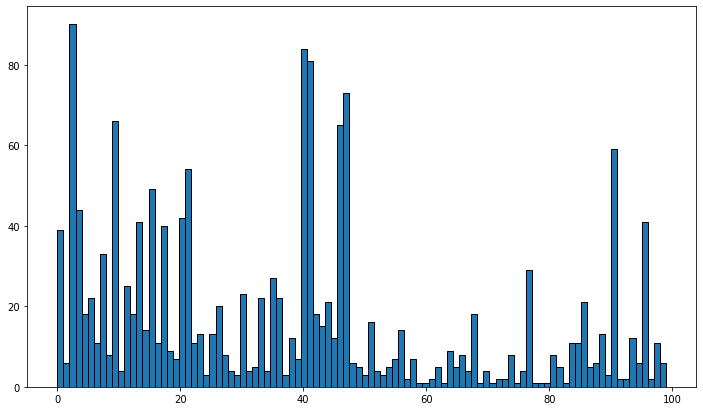

In [5]:
from sklearn.cluster import DBSCAN, AffinityPropagation, AgglomerativeClustering, SpectralClustering

# clustering = DBSCAN(eps=9, min_samples=5, metric='precomputed').fit(time_matrix)
# clustering = AffinityPropagation(affinity='precomputed').fit(time_matrix)
clustering = AgglomerativeClustering(n_clusters=100, affinity='precomputed', linkage='complete').fit(time_matrix)
plt.figure(figsize=(12, 7))
plt.hist(clustering.labels_, ec='black', bins=100)
plt.show()

In [6]:
# top_idx = np.argsort(-solver.density)[-100:]
top_idx = np.where(clustering.labels_ == 0)[0]

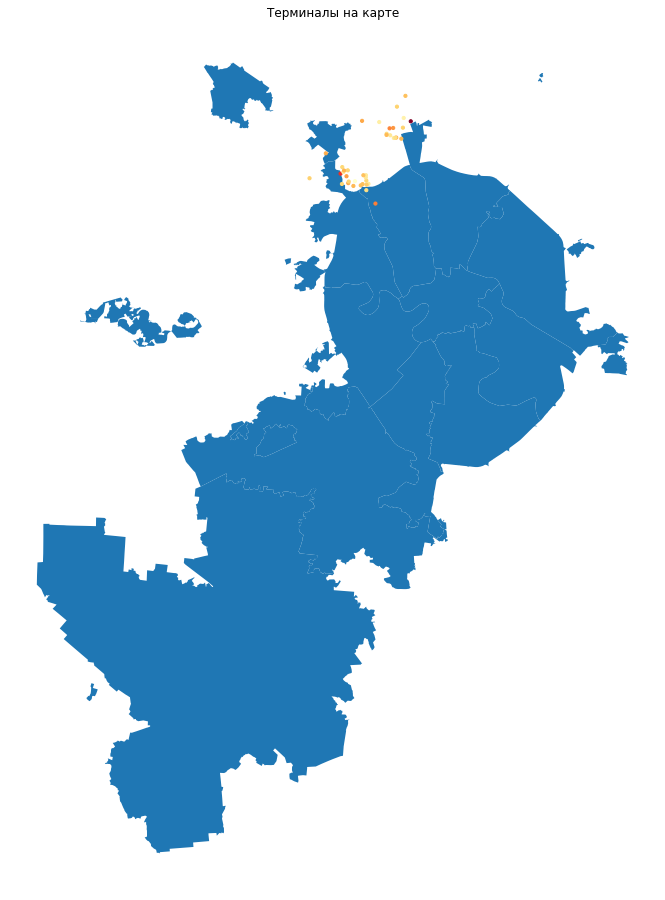

In [7]:
fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)
color_vals = terms['remains 91'].iloc[top_idx] # np.median(terms[columns[2:]].values, axis=1).clip(1e-6)
ax.scatter(terms['longitude'].iloc[top_idx], terms['latitude'].iloc[top_idx], s=10, c=color_vals,
            norm=colors.LogNorm(vmin=color_vals.min(), vmax=color_vals.max()), cmap='YlOrRd')

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()

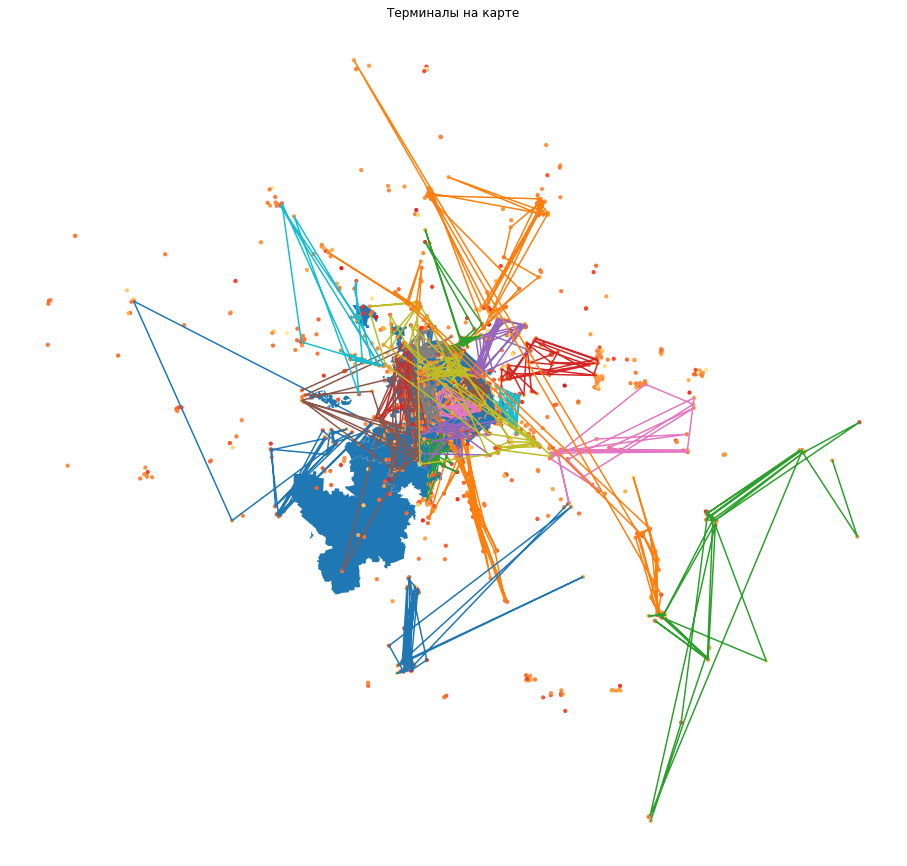

In [8]:
fig, ax = plt.subplots(figsize=(16, 16))
moscow.plot(ax=ax)
color_vals = terms['remains 91'] # np.median(terms[columns[2:]].values, axis=1).clip(1e-6)
ax.scatter(terms['longitude'], terms['latitude'], s=10, c=color_vals,
            norm=colors.LogNorm(vmin=color_vals.min(), vmax=color_vals.max()), cmap='YlOrRd')

for route in routes:
    plt.plot(terms['longitude'].iloc[route], terms['latitude'].iloc[route])

plt.axis('off')
plt.title('Терминалы на карте')
plt.show()